# RQ1 - Popularity

Uses:

- resources/database.xlsx
- resources/filtered_projects_2024 - 07_09_24.xlsx (ANNOTATED_JAVA_COMPLET)

Generates:

- relation_and_nonRelational.pdf (fig:rq1)
- Top-5-domains.pdf (fig:Top-5-domains)

Variables:

- rq1_multimodel
- rq1_dbms_total
- rq1_multimodel_both
- rq1_dbms_multimodel_combined
- rq1_projects_with_dbms
- rq1_no_dbms
- rq1_mysql
- rq1_postgresql
- rq1_h2
- rq1_oracle
- rq1_redis
- rq1_relational_dbms
- rq1_relational_dbms_found
- rq1_non_relational_dbms
- rq1_non_relational_dbms_found
- rq1_mongodb
- rq1_relational
- rq1_non_relational
- rq1_model_intersection
- rq1_multimodel
- rq1_multimodel_ext


In [1]:
import sys  
sys.path.insert(1, '..')

In [2]:
#!pip install num2words
#!pip install matplotlib_venn


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os

from num2words import num2words
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles


from analysis_helpers import var, load_vars, relative_var
from analysis_helpers import (
    RELATIONAL_ONLY_DBS, NONRELATIONAL_ONLY_DBS,
    MULTIMODEL_RELATIONAL, MULTIMODEL_NONRELATIONAL,
    RELATIONAL_DBS, NONRELATIONAL_DBS, MULTIMODEL_DBS
)
from util import RESOURCE_DIR, IMAGES_DIR

/Users/camilapaiva/.local/share/virtualenvs/db-mining-TZwk5hDq/lib/python3.9/site-packages/matplotlib_venn/_math.py:12: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.2)
  from scipy.optimize import brentq


In [4]:
CHARACTERIZATION_FILE_PATH = RESOURCE_DIR + os.sep + 'database.xlsx'
df = pd.read_excel(CHARACTERIZATION_FILE_PATH, engine = 'openpyxl')
data_with_index = df.set_index("name")
data_with_index.reset_index(inplace=True)

data_with_index.head()

,name,owner,domain,sha1,part_commit,date_commit,isLast,SapHana,Realm,SAP SQL Anywhere,...,ClickHouse,Kdb+,Virtuoso-NoSql,HBase,Firebird,Cassandra,Couchbase,Etcd,PostGIS,Redis
0,Activiti,Activiti,Enterprise Resource Planning,18facf90f45c567b3c9040bd83cca7e1c586387f,NaN,2024-10-11 20:12:54+00:00,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,lottie-android,airbnb,Game,e320c993c4ee501b488dadb0a6bfe64f91ce7404,NaN,2024-10-04 18:54:43+00:00,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spring-cloud-alibaba,alibaba,Software Development,fadd6ba4228063ba8a2b25509d85d27d78359b5a,NaN,2024-09-27 12:04:25+00:00,True,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,nacos,alibaba,Infrastructure Management,b97116458c756ab35c1aa5e7e45ae77c8ecca356,NaN,2024-10-15 02:13:03+00:00,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,fastjson,alibaba,Data Management,c942c83443117b73af5ad278cc780270998ba3e1,NaN,2023-05-12 06:16:03+00:00,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
columns_to_drop = ['sha1', 'part_commit', 'date_commit', 'isLast', 'owner']
data_with_index = data_with_index.drop(columns=columns_to_drop)

data_with_index.rename(columns={'MySQL_Maria DB': 'MySQL'}, inplace=True)
data_with_index.rename(columns={'PostgreSQL_ CockroachDB': 'PostgreSQL'}, inplace=True)
data_with_index.rename(columns={'MS SQL Server_Microsoft Azure SQL Database': 'MS SQL Server'}, inplace=True)
data_with_index.rename(columns={'GoogleCloudFilestore': 'GoogleCloudFirestore'}, inplace=True)

# Drop columns that combine multimodel
data_with_index.drop('Virtuoso', axis=1, inplace=True)
data_with_index.drop('Ignite', axis=1, inplace=True)
print('Multimodel:', var("rq1_multimodel", num2words(2)))

data_with_index.head()

Multimodel: two


,name,domain,SapHana,Realm,SAP SQL Anywhere,FileMaker,ArangoDB,Informix,HyperSQL,CouchDB,...,ClickHouse,Kdb+,Virtuoso-NoSql,HBase,Firebird,Cassandra,Couchbase,Etcd,PostGIS,Redis
0,Activiti,Enterprise Resource Planning,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,lottie-android,Game,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spring-cloud-alibaba,Software Development,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,nacos,Infrastructure Management,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,fastjson,Data Management,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## DBMS aspect

### Data

In [6]:
dbms_usages = data_with_index.iloc[: , 2:].sum().sort_values(ascending=False)
dbms_usages

MySQL                            113
PostgreSQL                        93
H2                                90
Oracle                            82
Redis                             80
HyperSQL                          56
MS SQL Server                     55
MongoDB                           46
IBM DB2                           31
Google Cloud Datastore            30
DynamoDB                          30
SQLite                            29
Cassandra                         23
Hazelcast                         18
HBase                             16
ClickHouse                        12
MarkLogic                         12
Firebird                          11
Neo4j                             11
Informix                          10
PostGIS                           10
SapHana                            9
Snowflake                          8
Teradata                           8
SAP Adaptive Server                8
Microsoft Azure CosmosDB           7
MS Access                          7
E

In [7]:
print('Evidence of different DBMS:', var("rq1_dbms_total", (dbms_usages > 0).sum()))

Evidence of different DBMS: 47


Count Multimodel usage

In [8]:
combined_evidence = (
    int(((data_with_index['Virtuoso-Sql'] > 0) & (data_with_index['Virtuoso-NoSql'] > 0)).any())
    + int(((data_with_index['Ignite-Sql'] > 0) & (data_with_index['Ignite-NoSql'] > 0)).any())
)
print('Multimodel that uses both:', var("rq1_multimodel_both", num2words(combined_evidence)))

Multimodel that uses both: one


In [9]:
data_with_index_multimodel_combined = data_with_index.copy()
data_with_index_multimodel_combined["Virtuoso"] = data_with_index_multimodel_combined["Virtuoso-Sql"] + data_with_index_multimodel_combined["Virtuoso-NoSql"]
data_with_index_multimodel_combined["Ignite"] = data_with_index_multimodel_combined["Ignite-Sql"] + data_with_index_multimodel_combined["Ignite-NoSql"]
data_with_index_multimodel_combined.drop('Virtuoso-Sql', axis=1, inplace=True)
data_with_index_multimodel_combined.drop('Virtuoso-NoSql', axis=1, inplace=True)
data_with_index_multimodel_combined.drop('Ignite-Sql', axis=1, inplace=True)
data_with_index_multimodel_combined.drop('Ignite-NoSql', axis=1, inplace=True)


In [10]:
print('Evidence of different DBMS (without repeating multimodel):',
var("rq1_dbms_multimodel_combined", 
    (data_with_index_multimodel_combined.iloc[: , 2:].sum().sort_values(ascending=False) > 0).sum()))

Evidence of different DBMS (without repeating multimodel): 46


In [11]:
#Numero de projetos usando Database
total_projects = (data_with_index.iloc[:, 2:].sum(axis=1).sort_values(ascending=False) > 0).sum()
print('Projects with DBMS:', var("rq1_projects_with_dbms", total_projects))

Projects with DBMS: 202


In [12]:
#Numero de projetos SEM Database
print('Projects with no DBMS:',
var("rq1_no_dbms", (data_with_index.iloc[:, 2:].sum(axis=1).sort_values(ascending=False) == 0).sum()))

Projects with no DBMS: 160


In [13]:
assert dbms_usages.idxmax() == 'MySQL', "Paper: 'MySQL is the most popular DBMS.'"
assert dbms_usages.idxmax() == 'MySQL', "Paper: 'MySQL is the most popular relational DBMS in our corpus.'"
print('Projects with MySQL:', relative_var("rq1_mysql", dbms_usages['MySQL'], total_projects))

Projects with MySQL: 113 (55.9%)


In [14]:
assert dbms_usages.nlargest(2).index[-1] == 'PostgreSQL', "Paper: 'PostgreSQL comes in second place in our corpus'"
print('Projects with PostgreSQL:', relative_var("rq1_postgresql", dbms_usages['PostgreSQL'], total_projects))

Projects with PostgreSQL: 93 (46.0%)


In [15]:
assert dbms_usages.nlargest(3).index[-1] == 'H2', "Paper: 'H2 comes in third'"
print('Projects with H2:', relative_var("rq1_h2", dbms_usages['H2'], total_projects))

Projects with H2: 90 (44.6%)


In [16]:
assert dbms_usages.nlargest(4).index[-1] == 'Oracle', "Paper: 'Oracle comes next'"
print('Projects with Oracle:', relative_var("rq1_oracle", dbms_usages['Oracle'], total_projects))

Projects with Oracle: 82 (40.6%)


In [17]:
assert dbms_usages.nlargest(5).index[-1] == 'Redis', "Paper: 'Finally, in fifth place, Redis was discovered'"
assert dbms_usages.nlargest(5).index[-1] == 'Redis'
print('Projects with Redis:', relative_var("rq1_redis", dbms_usages['Redis'], total_projects))

Projects with Redis: 80 (39.6%)


In [18]:
assert set(dbms_usages.nlargest(5).index) - set(RELATIONAL_DBS) == {'Redis'}, "Paper: 'It is the only non-relational database found among the top 5 DBMS of our corpus'"

In [19]:
assert set(dbms_usages[dbms_usages == 1].index) == {'Microsoft Azure Table Storage', 'Impala', 'Aerospike'}, "Paper: 'Aerospike, Impala, and Microsoft Azure Table Storage appeared in just one project each'"

In [20]:
assert set(dbms_usages[dbms_usages == 0].index) == {'FileMaker', 'Interbase', 'Virtuoso-Sql'}, "Paper: 'Out of the 50 DBMSs we analyzed, Interbase, FileMaker, and Virtuoso-SQL showed no evidence of being used.'"

### _Display counts

(Not used in the paper)

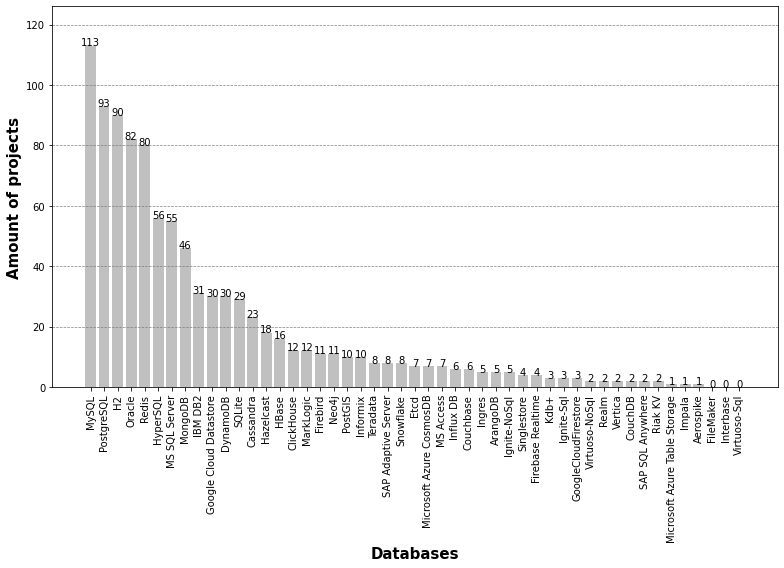

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,7))

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

df = data_with_index.iloc[:, 3:].sum().sort_values(ascending=False)

# Gráfico de barras
plt.bar(df.index, df.values, color='silver')
addlabels(df.index, df.values)

# Adicionando linhas horizontais nas marcações do eixo Y
y_ticks = plt.gca().get_yticks()  # Obtém as marcações do eixo Y

for y_tick in y_ticks:
    plt.axhline(y=y_tick, color='gray', linestyle='--', linewidth=0.7)  # Adiciona linhas horizontais

plt.xticks(rotation=90)
plt.xlabel("Databases", fontweight="bold", fontsize=15)
plt.ylabel("Amount of projects", fontweight="bold", fontsize=15)

#plt.title("Distributions of Databases in Java Projects")
plt.show()


### Display by model

Paper fig:rq1

Prepare dataframe to create bargraph

In [22]:
# Ajustando o df para que eu possa fazer o gráfico de forma empilhada
db_types = data_with_index.iloc[:, data_with_index.columns != 'domain']
db_types = db_types.set_index('name').transpose()
db_types.index.name = 'Databases'

map_dict = {name: "Relational" for name in RELATIONAL_DBS}

db_types['Model'] = db_types.index.to_series().map(map_dict)
db_types['Model'] = db_types['Model'].fillna("Non Relational")
model = db_types.pop("Model")
db_types.insert(0, "Model", model)
db_types['Relational'] = db_types.apply(lambda row: row.iloc[1:].sum() if row['Model'] == 'Relational' else 0, axis=1)
db_types['Non Relational'] = db_types.apply(lambda row: row.iloc[1:].sum() if row['Model'] == 'Non Relational' else 0, axis=1)

#db_types.loc[['MarkLogic'], 'Model'] = 'Multi Model' #'Virtuoso', 'Ignite', Retirei pois estava com erro.
#db_types.loc['Virtuoso', 'Relational'] = 0
#db_types.loc['Virtuoso', 'Non Relational'] = 2
#db_types.loc['Ignite', 'Relational'] = 3
#db_types.loc['Ignite', 'Non Relational'] = 5
#db_types.loc['MarkLogic', 'Relational'] = 0
#db_types.loc['MarkLogic', 'Non Relational'] = 3

db_types.rename(columns={'name':  ''},)
db_types.rename(columns={'GoogleCloudFilestore':  'GoogleCloudFirestore'},)
#db_types.to_excel("output.xlsx")


name,Model,Activiti,lottie-android,spring-cloud-alibaba,nacos,fastjson,aliyun-openapi-java-sdk,alluxio,FXGL,AntennaPod,...,wildfly,Universal-G-Code-Sender,xxl-job,yacy_search_server,zaproxy,maxwell,zxing,liferay-portal,Relational,Non Relational
Databases,,,,,,,,,,,,,,,,,,,,,
SapHana,Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0
Realm,Non Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
SAP SQL Anywhere,Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
FileMaker,Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ArangoDB,Non Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
Informix,Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
HyperSQL,Relational,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,56,0
CouchDB,Non Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Riak KV,Non Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


DBMSs classified by data model

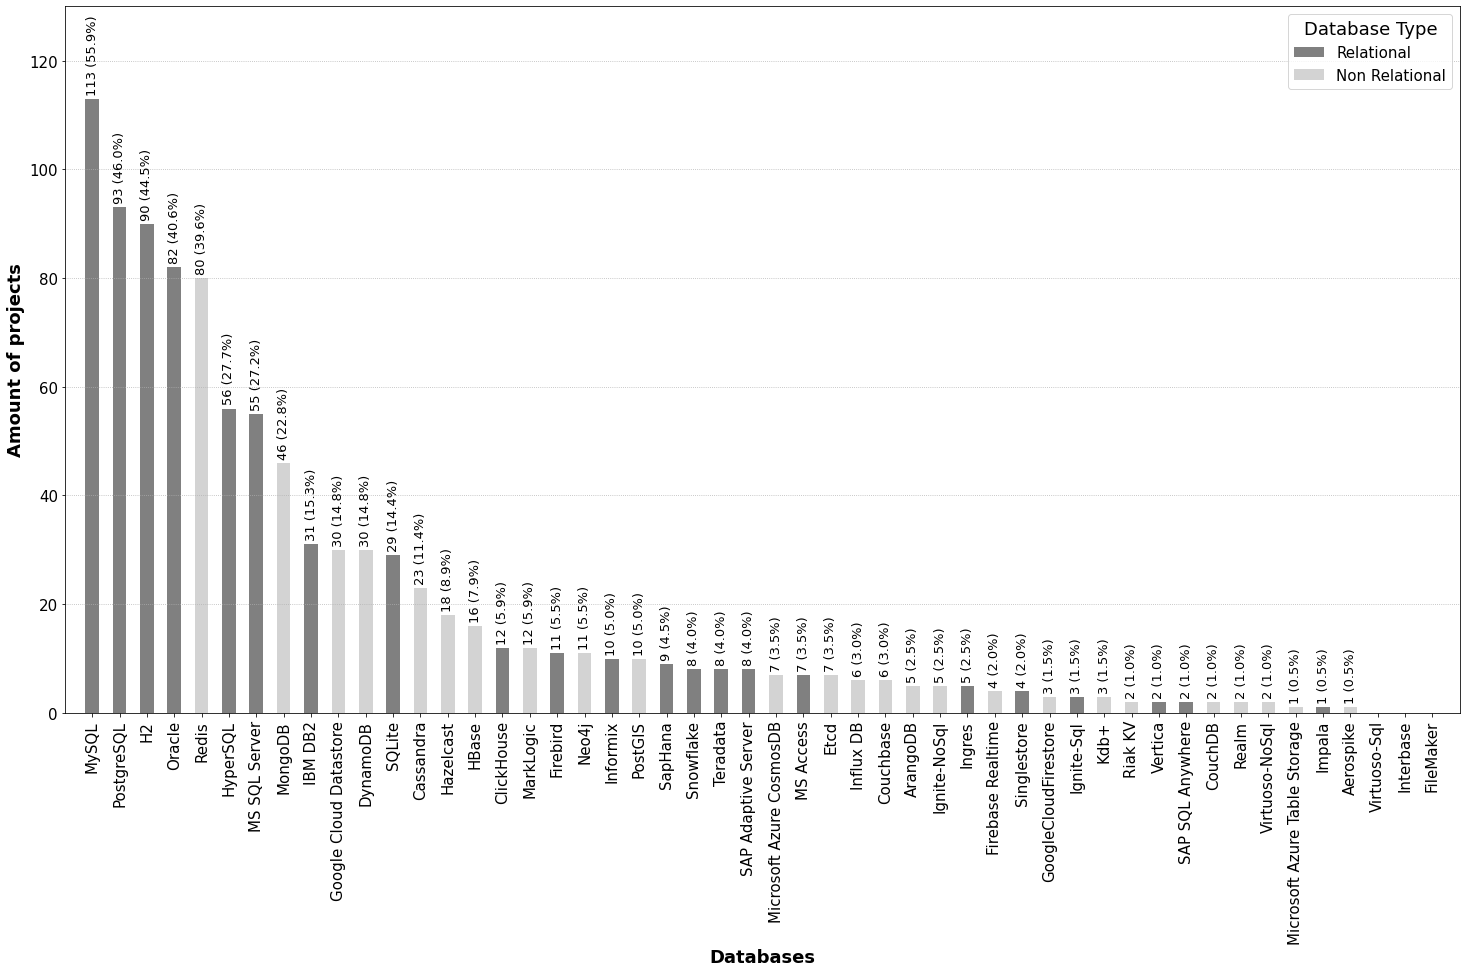

In [23]:
# Preparação dos dados (mesmo que já estava)
df_graph = db_types[['Model', 'Relational', 'Non Relational']].copy()
df_graph['Amount of Projects'] = db_types['Relational'] + db_types['Non Relational']
#df_graph.drop(['Ignite-NoSql'], inplace=True)  # Remover banco específico
#df_graph.drop(['Ignite'], inplace=True)  # Remover banco específico
#df_graph.drop(['Virtuoso'], inplace=True)  # Remover banco específico
#df_graph.drop(['Virtuoso-NoSql'], inplace=True)  # Remover banco específico
#df_graph.rename(columns={'name': 'Projects'}, inplace=True)

df_graph = df_graph.sort_values(by='Amount of Projects', ascending=False)

# Define uma paleta de cores
plt.rc('axes', prop_cycle=plt.cycler('color', ['gray', 'lightgray']))

# Cria o gráfico de barras empilhadas
ax = df_graph.plot(y=['Relational', 'Non Relational'], kind='bar', stacked=True, figsize=(25, 13), fontsize=15)
ax.legend(title="Database Type", fontsize=15, title_fontsize=18)
# Configurações do eixo
ax.set_xlabel("Databases", fontsize=18, fontweight='bold')
ax.set_ylabel("Amount of projects", fontsize=18, fontweight='bold')
ax.set_xlim(left=-1, right=50)  # Limita o eixo X entre 0 e 10
ax.set_ylim(bottom=0, top=130)  # Limita o eixo Y entre 0 e 100




# Remove as anotações (números) nas barras
for i in ax.patches:  
     if i.get_height() != 0:
         percentage = round((int(i.get_height()) / 202) * 100, 2) #202 é o número de projetos com BD. Voltar aqui para calcular de forma dinâmnica.
         total = int(i.get_height())
         annotateResult = f"{total} ({percentage:.1f}%)"
         ax.annotate(str(annotateResult), (i.get_x() + i.get_width() / 2, i.get_height()),
                     ha='center', va='baseline', fontsize=13, color='black', 
                     xytext=(0, 7), textcoords='offset points', rotation=90)

# Adiciona grid pontilhado no eixo Y
plt.grid(axis='y', linestyle=':', linewidth=0.8)

# Salvar como PDF
plt.savefig(IMAGES_DIR + "/relation_and_nonRelational.pdf", format="pdf", bbox_inches="tight")
plt.show()

#juntas os bancos SQL e Não SQL


## Model Aspect

### Data

In [24]:
relational_usages = dbms_usages[dbms_usages.index.isin(RELATIONAL_DBS)]
total_relational_dbms = len(relational_usages)
print("Relational DBMSs:", var("rq1_relational_dbms", total_relational_dbms))
print("Relational DBMSs Found:", relative_var("rq1_relational_dbms_found", (relational_usages > 0).sum(), total_relational_dbms))

Relational DBMSs: 25
Relational DBMSs Found: 22 (88.0%)


In [25]:
non_relational_usages = dbms_usages[~dbms_usages.index.isin(RELATIONAL_DBS)]
total_non_relational_dbms = len(non_relational_usages)
print("Non-Relational DBMSs:", var("rq1_non_relational_dbms", total_non_relational_dbms))
print("Non-Relational DBMSs Found:", relative_var("rq1_non_relational_dbms_found", (non_relational_usages > 0).sum(), total_non_relational_dbms))

Non-Relational DBMSs: 25
Non-Relational DBMSs Found: 25 (100.0%)


In [26]:
assert list(non_relational_usages.nlargest(2).index) == ['Redis', 'MongoDB'], "Paper: 'For non-relational databases, the DBMSs for which we found more usage evidence were Redis and MongoDB'"

In [27]:
assert non_relational_usages.nlargest(2).index[-1] == 'MongoDB', "Paper: 'For non-relational databases, the DBMSs for which we found more usage evidence were Redis and MongoDB'"
print('Projects with MongoDB:', relative_var("rq1_mongodb", non_relational_usages['MongoDB'], total_projects))

Projects with MongoDB: 46 (22.8%)


In [28]:
assert (non_relational_usages == 0).sum() == 0, "Paper: 'Using our database heuristics to search the project corpus, we found evidence of the use of all of the 25 non-relational databases we searched for (100\%)'"

In [29]:
# Seleciona as colunas que correspondem aos bancos relacionais no DataFrame
df_relational = data_with_index[RELATIONAL_ONLY_DBS]

# Verifica em cada linha se pelo menos um banco relacional foi usado (se há valor 1)
projects_using_relational = df_relational.any(axis=1)

# Conta quantos projetos usaram pelo menos um banco relacional
count_projects = projects_using_relational.sum()

print("Número total de projetos que usaram pelo menos um banco relacional:", 
      relative_var("rq1_relational", count_projects, total_projects))


Número total de projetos que usaram pelo menos um banco relacional: 166 (82.2%)


In [30]:
# Seleciona as colunas que **não** estão na lista de bancos relacionais
non_relational_cols = data_with_index.columns.difference(RELATIONAL_DBS + MULTIMODEL_NONRELATIONAL + ['domain', 'name'])
#print(non_relational_cols)

# Seleciona apenas as colunas que correspondem aos bancos **não relacionais** no DataFrame
df_non_relational = data_with_index[non_relational_cols]

# Verifica em cada linha se pelo menos um banco não relacional foi usado (se há valor 1)
projects_using_non_relational = df_non_relational.any(axis=1)

# Conta quantos projetos usaram pelo menos um banco não relacional
count_non_relational_projects = projects_using_non_relational.sum()

print("Número total de projetos que usaram pelo menos um banco não relacional:",
      relative_var("rq1_non_relational", count_non_relational_projects, total_projects))


Número total de projetos que usaram pelo menos um banco não relacional: 138 (68.3%)


In [31]:
# Calcula a interseção: projetos que usaram ao menos um banco relacional e um não relacional
projects_intersection = projects_using_relational & projects_using_non_relational

# Conta quantos projetos estão na interseção
count_intersection = projects_intersection.sum()

print("Número total de projetos que usaram pelo menos um banco relacional e um não relacional",
      relative_var("rq1_model_intersection", count_intersection, total_projects))


Número total de projetos que usaram pelo menos um banco relacional e um não relacional 103 (51.0%)


In [32]:
# Lista de bancos de dados relacionais

# Seleciona as colunas que correspondem aos bancos relacionais no DataFrame
df_multimodel = data_with_index[MULTIMODEL_DBS]

# Verifica em cada linha se pelo menos um banco relacional foi usado (se há valor 1)
projects_using_multimodel = df_multimodel.any(axis=1)

# Conta quantos projetos usaram pelo menos um banco relacional
count_projects = projects_using_multimodel.sum()

print("Número total de projetos que usaram pelo menos um banco multimodelo",
      relative_var("rq1_multimodel", count_projects, total_projects))
var("rq1_multimodel_ext", num2words(count_projects))

Número total de projetos que usaram pelo menos um banco multimodelo 8 (4.0%)


'eight'

### _Display intersection

(Not used in the paper)

In [33]:
db_types

name,Model,Activiti,lottie-android,spring-cloud-alibaba,nacos,fastjson,aliyun-openapi-java-sdk,alluxio,FXGL,AntennaPod,...,wildfly,Universal-G-Code-Sender,xxl-job,yacy_search_server,zaproxy,maxwell,zxing,liferay-portal,Relational,Non Relational
Databases,,,,,,,,,,,,,,,,,,,,,
SapHana,Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0
Realm,Non Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
SAP SQL Anywhere,Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
FileMaker,Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ArangoDB,Non Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
Informix,Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
HyperSQL,Relational,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,56,0
CouchDB,Non Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Riak KV,Non Relational,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


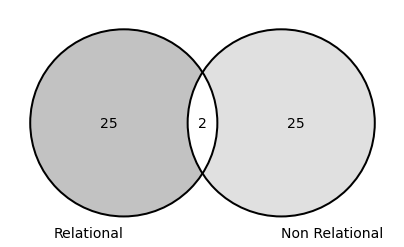

In [34]:
plt.figure(figsize=(7,7))
A = len(RELATIONAL_DBS)
B = len(NONRELATIONAL_DBS)
AB = len(MULTIMODEL_RELATIONAL)

venn = venn2(subsets = (A, B, AB), set_labels=('Relational', 'Non Relational'), set_colors=('darkgray', 'lightgray'), alpha= 0.7)
venn2_circles(subsets=(A, B, AB))

for text in venn.set_labels:  #change label size
    text.set_fontsize(14);
for text in venn.subset_labels:  #change number size
    text.set_fontsize(14)

#plt.savefig(IMAGES_DIR+"/fig10.pdf", format="pdf", bbox_inches="tight")

In [35]:
import pandas as pd

# Carregar os DataFrames
# Suponha que 'projects_df' é o DataFrame que contém os projetos e bancos usados
# E 'relational_models_df' é o DataFrame que contém os modelos relacionais
projects_df = data_with_index
projects_df = projects_df.drop(columns=['domain'])

projects_df_Trasponse = projects_df.T

projects_df_Trasponse.columns = projects_df_Trasponse.iloc[0] 
projects_df_Trasponse = projects_df_Trasponse.drop(projects_df_Trasponse.index[0]) 

#projects_df_Trasponse = projects_df_Trasponse.rename(columns={'Projects': 'Databases'}, inplace=True)



projects_df_Trasponse['BD Type'] = projects_df_Trasponse.index.map(
    lambda x: 'Relational' if x in RELATIONAL_DBS else ('Non Relational' if x in NONRELATIONAL_DBS else 'Multi Model')
)

projects_df_Trasponse



name,Activiti,lottie-android,spring-cloud-alibaba,nacos,fastjson,aliyun-openapi-java-sdk,alluxio,FXGL,AntennaPod,antlr4,...,dynmap,wildfly,Universal-G-Code-Sender,xxl-job,yacy_search_server,zaproxy,maxwell,zxing,liferay-portal,BD Type
SapHana,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Relational
Realm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Non Relational
SAP SQL Anywhere,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Relational
FileMaker,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Relational
ArangoDB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Non Relational
Informix,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Relational
HyperSQL,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,Relational
CouchDB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Non Relational
Riak KV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Non Relational
Virtuoso-Sql,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Relational


### _Display Relational

(Not used in the paper)

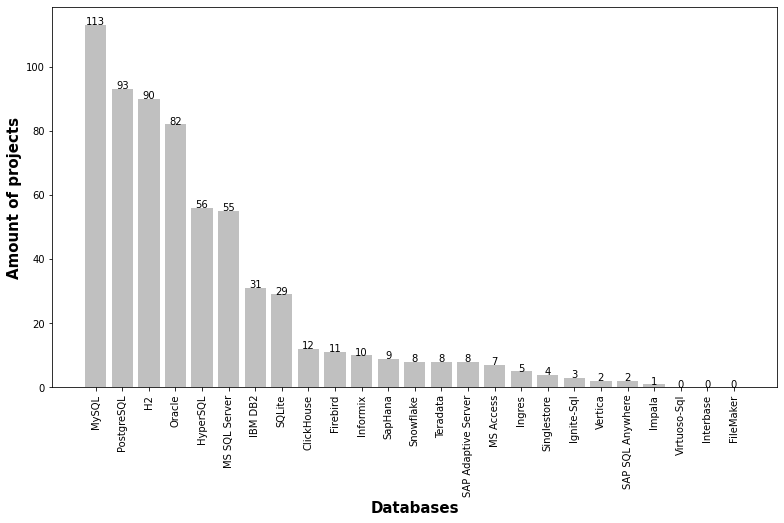

In [36]:
# Graph DBMS by Relational Model
plt.figure(figsize=(13,7))

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

plt.bar(relational_usages.index, relational_usages.values, color = 'silver')
addlabels(relational_usages.index, relational_usages.values)
plt.xticks(rotation=90)
plt.xlabel("Databases", fontweight = "bold", fontsize = 15)
plt.ylabel("Amount of projects", fontweight = "bold", fontsize = 15)

plt.show() 

### _Display Non-Relational

(Not used in the paper)


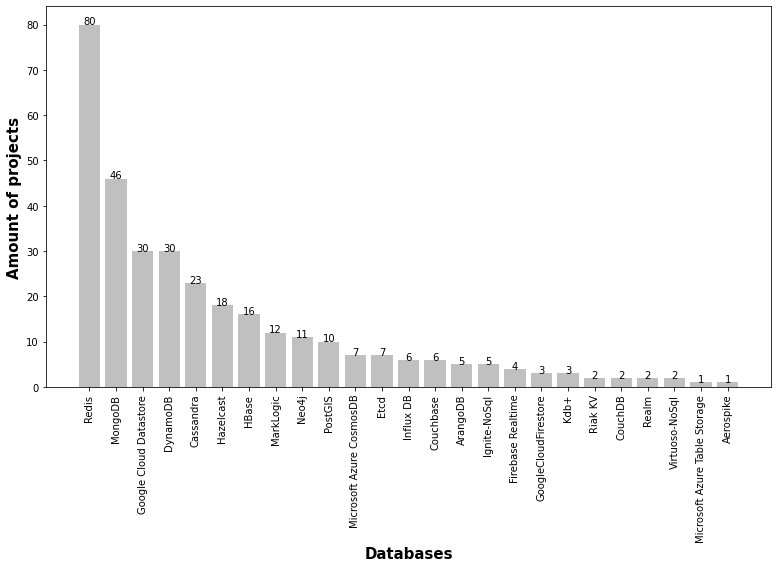

In [37]:
# Graph DBSM by Non Relational Model
plt.figure(figsize=(13,7))

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

plt.bar(non_relational_usages.index, non_relational_usages.values, color = 'silver')
addlabels(non_relational_usages.index, non_relational_usages.values)
plt.xticks(rotation=90)
plt.xlabel("Databases", fontweight = "bold", fontsize = 15)
plt.ylabel("Amount of projects", fontweight = "bold", fontsize = 15)

plt.show() 

## Domain Aspect

In [38]:
# Get frequency of values in the 'Domains' column
freq_domains = data_with_index['domain'].value_counts()
freq_domains

Software Development            93
Data Management                 69
Infrastructure Management       32
Program Analysis                25
Security                        21
Automation                      18
Game                            16
Network                         16
Monitoring                      12
Media                           11
Enterprise Resource Planning     9
Personal Management              8
Collaboration                    7
Artificial Intelligence          6
Cryptocurrency                   5
File Management                  5
Other                            3
High Performance Computing       3
Finances                         1
infrastructure Management        1
Artificial Intelligence          1
Name: domain, dtype: int64

In [39]:
import pandas as pd
from util import ANNOTATED_FILE_JAVA_COMPLET

#Retorna aqui os valores do arquivo padrão Annotated Java
df = pd.read_excel(ANNOTATED_FILE_JAVA_COMPLET, keep_default_na=False, sheet_name='2021')
df1 = df[df['discardReason'] == ''] #filtra os projetos sem discardReason
#df1 = pd.read_excel('arquivo2.xlsx')  # DataFrame 2

df_domanins = df1['domain'].value_counts()
df_domanins

Software Development            93
Data Management                 69
Infrastructure Management       33
Program Analysis                25
Security                        21
Automation                      18
Network                         16
Game                            16
Monitoring                      12
Media                           11
Enterprise Resource Planning     9
Personal Management              8
Artificial Intelligence          7
Collaboration                    7
Cryptocurrency                   5
File Management                  5
Other                            3
High Performance Computing       3
Finances                         1
Name: domain, dtype: int64

In [40]:
# Get the top 5 most frequent domains
most_popular_domains = freq_domains.head()
most_popular_domains = most_popular_domains.index
most_popular_domains

Index(['Software Development', 'Data Management', 'Infrastructure Management',
       'Program Analysis', 'Security'],
      dtype='object')

In [41]:
assert list(most_popular_domains) == [
    'Software Development', 'Data Management',
    'Infrastructure Management', 'Program Analysis', 'Security'
], "Paper: 'DBMS by the top 5 application domains: Software Development, Data Management, Infrastructure Management, Program Analysis and Security.'"

In [42]:
data_group_by_domain =  data_with_index[data_with_index['domain'].isin(most_popular_domains)]
data_group_by_domain

,name,domain,SapHana,Realm,SAP SQL Anywhere,FileMaker,ArangoDB,Informix,HyperSQL,CouchDB,...,ClickHouse,Kdb+,Virtuoso-NoSql,HBase,Firebird,Cassandra,Couchbase,Etcd,PostGIS,Redis
2,spring-cloud-alibaba,Software Development,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,nacos,Infrastructure Management,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,fastjson,Data Management,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,aliyun-openapi-java-sdk,Infrastructure Management,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,alluxio,Data Management,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,wildfly,Infrastructure Management,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
357,yacy_search_server,Infrastructure Management,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
358,zaproxy,Security,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
359,maxwell,Data Management,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Display by domain

fig:Top-5-domains

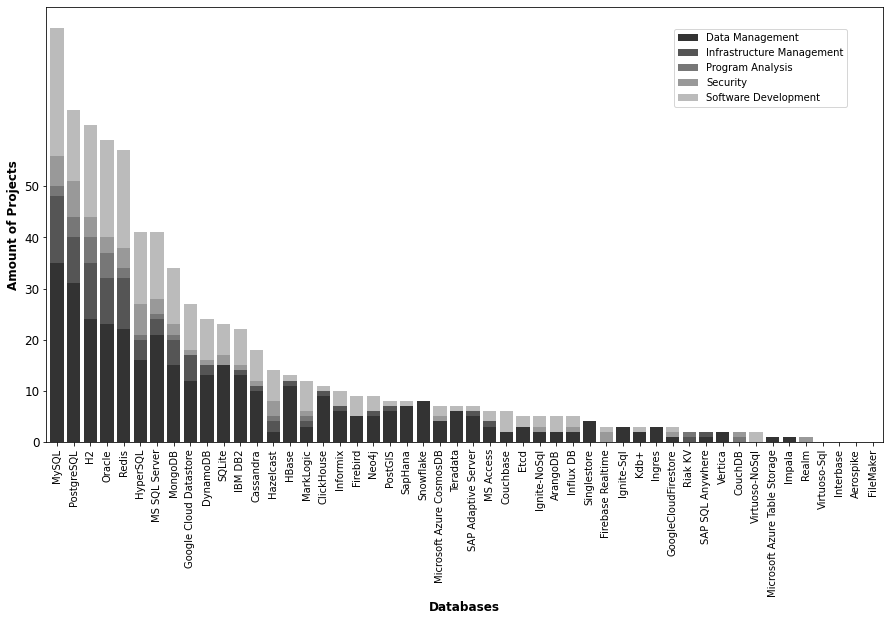

In [43]:
import matplotlib.pyplot as plt

grouped_data = data_group_by_domain.groupby('domain').sum()

transposed_data = grouped_data.transpose()

# Sort the transposed data in descending order based on Amount of projects
transposed_data['Total'] = transposed_data.sum(axis=1)
transposed_data.sort_values(by='Total', inplace=True, ascending=False)
transposed_data.drop('Total', axis=1, inplace=True)

# Define grayscale colors
gray_colors = ['#333333', '#555555', '#777777', '#999999', '#BBBBBB']

# Create a stacked bar chart
ax = transposed_data.plot(kind='bar', stacked=True, figsize=(15, 8), color = gray_colors, width = 0.8)

# Set chart labels
plt.xlabel('Databases', fontsize=12, fontweight='bold')
plt.ylabel('Amount of Projects', fontsize=12, fontweight='bold')

# Rotate x-axis labels and set their color and weight
plt.xticks(rotation=90)

# Set y-axis ticks and labels
plt.yticks(range(0, 60, 10), fontsize=12)

# Adiciona grid pontilhado no eixo Y
#plt.grid(axis='y', linestyle=':', linewidth=0.8)


# Display the legend outside the plot
plt.legend(bbox_to_anchor=(0.75, 0.95), loc='upper left', borderaxespad=0.)
plt.savefig(IMAGES_DIR+"/Top-5-domains.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.show()



### Data

In [44]:
dbms_usages_in_top5_domains = grouped_data.sum().sort_values(ascending=False)

In [45]:
assert list(dbms_usages_in_top5_domains.nlargest(5).index) == [
    'MySQL', 'PostgreSQL', 'H2', 'Oracle', 'Redis'
], "Paper: 'We observe that the most used DBMSs among the top-5 domains are MySQL, PostgreSQL, H2, Oracle, and Redis'"

In [46]:
software_development = transposed_data["Software Development"].sort_index(ascending=False).sort_values(ascending=False)

In [47]:
software_development.nlargest(5)

MySQL         25
Redis         19
Oracle        19
H2            18
PostgreSQL    14
Name: Software Development, dtype: int64

In [48]:
print("DBMSs used in software development projects:",
      var("rq1_software_development_dbms", (software_development > 0).sum()))
assert list(software_development.nlargest(5).index) == [
    'MySQL', 'Redis', 'Oracle', 'H2', 'PostgreSQL'
], "Paper: 'The most used are MySQL, Redis, Oracle, H2, and PostgreSQL'"

DBMSs used in software development projects: 35


In [49]:
data_management = transposed_data["Data Management"].sort_values(ascending=False)
infrastructure_management = transposed_data["Infrastructure Management"].sort_values(ascending=False)


In [50]:
assert list(data_management.nlargest(1).index) == ['MySQL'], "Paper: 'MySQL is the most popular relational DBMS in our corpus. It is the most used DBMS in the Software Development, Data Management, and Infrastructure Management domains.'"
assert list(infrastructure_management.nlargest(1).index) == ['MySQL'], "Paper: 'MySQL is the most popular relational DBMS in our corpus. It is the most used DBMS in the Software Development, Data Management, and Infrastructure Management domains.'"

In [51]:
dbms_usages_in_top5_domains_non_relational = dbms_usages_in_top5_domains[~dbms_usages_in_top5_domains.index.isin(RELATIONAL_DBS)].sort_values(ascending=False)

In [52]:
assert list(dbms_usages_in_top5_domains_non_relational.nlargest(1).index) == [
    'Redis'
], "Paper: 'As for non-relational DBMS, the most used is Redis.'"

In [53]:
data_management_non_relational = transposed_data["Data Management"][~transposed_data["Data Management"].index.isin(RELATIONAL_DBS)].sort_values(ascending=False)
software_development_non_relational = transposed_data["Software Development"][~transposed_data["Software Development"].index.isin(RELATIONAL_DBS)].sort_values(ascending=False)
infrastructure_management_non_relational = transposed_data["Infrastructure Management"][~transposed_data["Infrastructure Management"].index.isin(RELATIONAL_DBS)].sort_values(ascending=False)


In [54]:
assert list(data_management_non_relational.nlargest(1).index) == ['Redis'], "Paper: 'It is also the most used non-relational DBMS in the Data Management, Software Development, and Infrastructure Management domains'"
assert list(software_development_non_relational.nlargest(1).index) == ['Redis'], "Paper: 'It is also the most used non-relational DBMS in the Data Management, Software Development, and Infrastructure Management domains'"
assert list(infrastructure_management_non_relational.nlargest(1).index) == ['Redis'], "Paper: 'It is also the most used non-relational DBMS in the Data Management, Software Development, and Infrastructure Management domains'"


### _Other

(Not used in the paper)

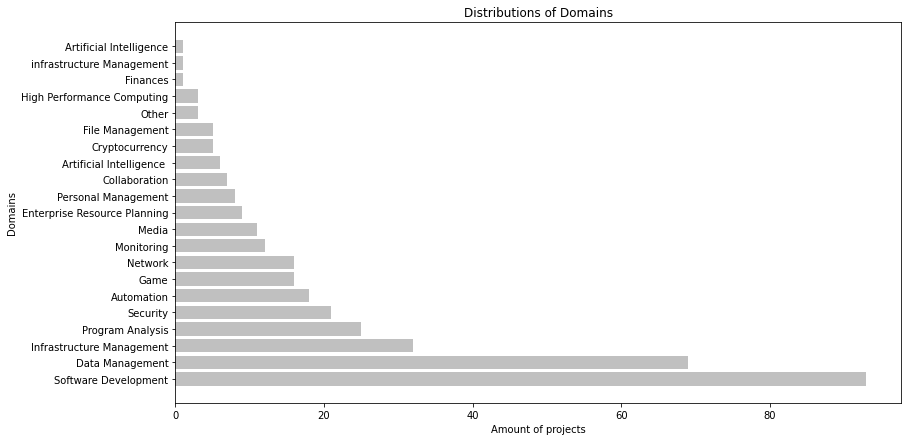

In [55]:
plt.figure(figsize=(13,7))

df = data_with_index.domain.value_counts()
plt.barh(df.index, df.values, color='silver')
#plt.xticks(rotation=90)

plt.title("Distributions of Domains")
plt.xlabel("Amount of projects")
plt.ylabel("Domains")
plt.show() 

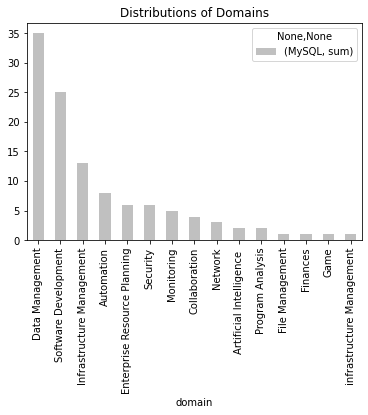

In [56]:
filtered_df = data_with_index.groupby('domain').agg({'MySQL':['sum']})
filtered_df = filtered_df[filtered_df['MySQL']['sum'] > 0]
result = filtered_df.sort_values(by=('MySQL','sum'), ascending=False).plot(kind='bar', color='silver',title = 'Distributions of Domains')

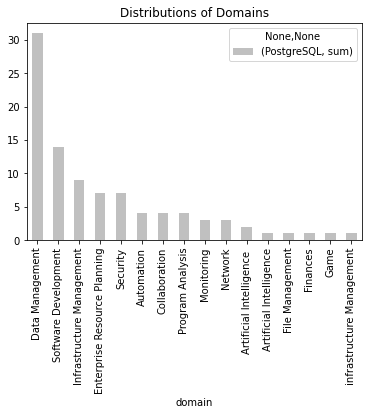

In [57]:
filtered_df = data_with_index.groupby('domain').agg({'PostgreSQL':['sum']})
filtered_df = filtered_df[filtered_df['PostgreSQL']['sum'] > 0]
result = filtered_df.sort_values(by=('PostgreSQL','sum'), ascending=False).plot(kind='bar', color='silver',title = 'Distributions of Domains')

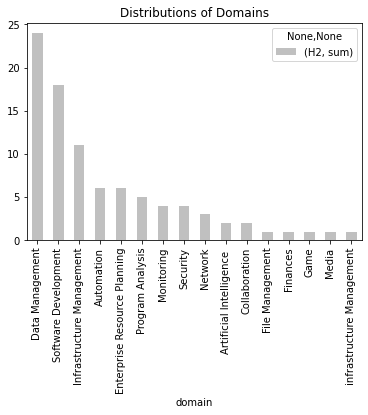

In [58]:

filtered_df = data_with_index.groupby('domain').agg({'H2':['sum']})
filtered_df = filtered_df[filtered_df['H2']['sum'] > 0]
result = filtered_df.sort_values(by=('H2','sum'), ascending=False).plot(kind='bar', color='silver',title = 'Distributions of Domains')


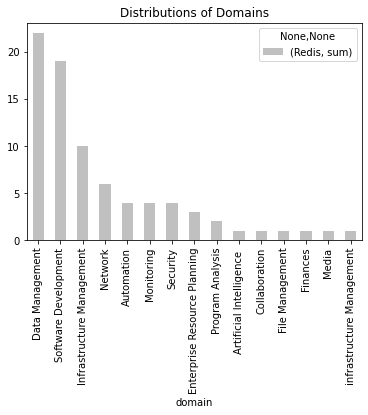

In [59]:
filtered_df = data_with_index.groupby('domain').agg({'Redis':['sum']})
filtered_df = filtered_df[filtered_df['Redis']['sum'] > 0]
result = filtered_df.sort_values(by=('Redis','sum'), ascending=False).plot(kind='bar', color='silver',title = 'Distributions of Domains')

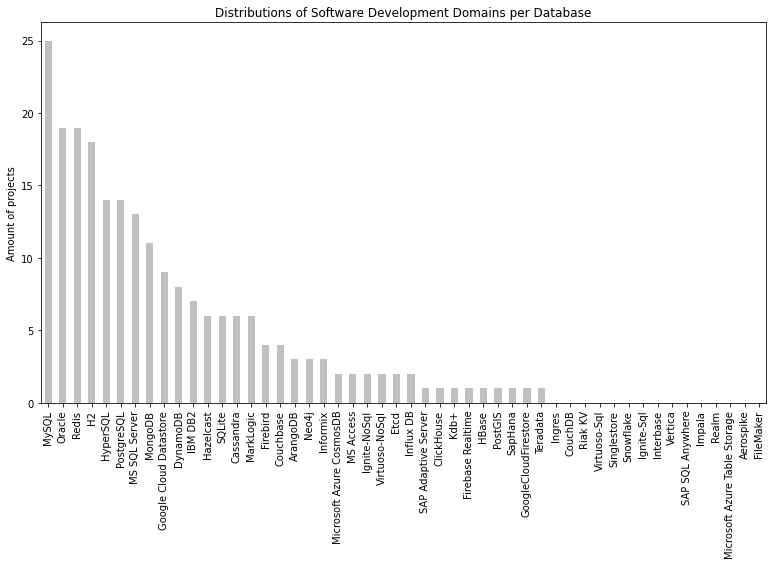

Text(0, 0.5, 'Amount of projects')

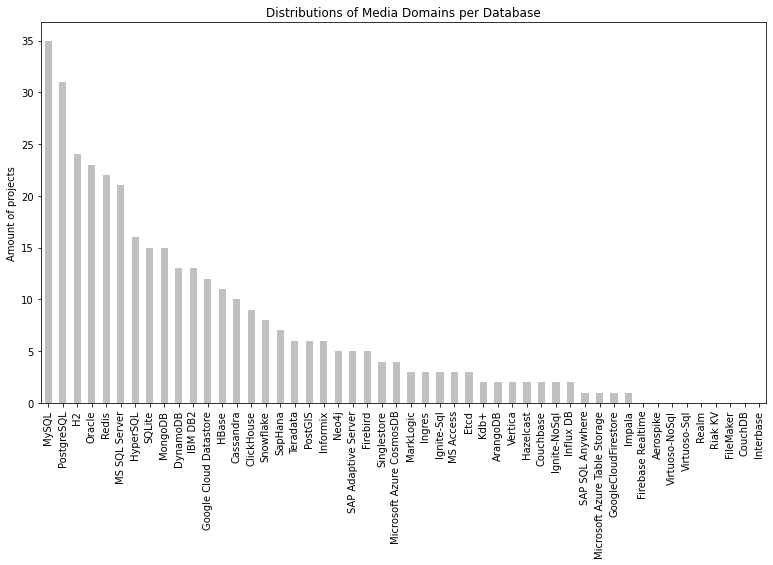

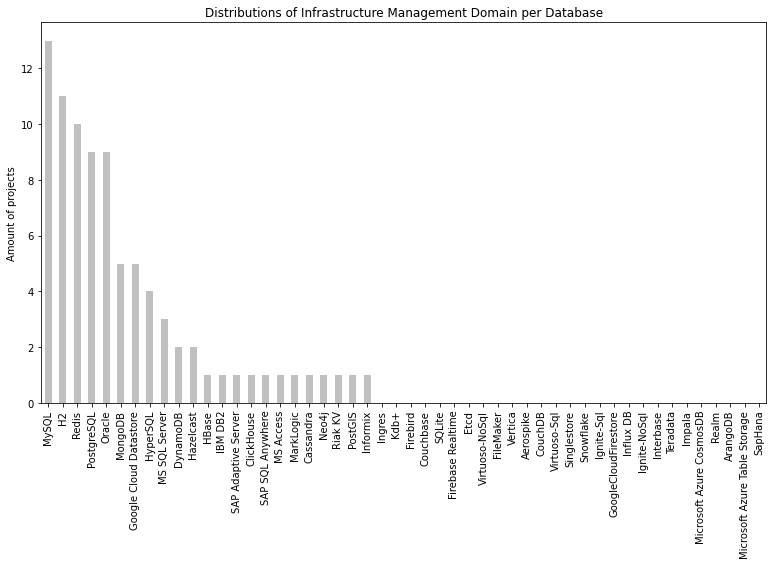

In [60]:


plt.figure(figsize=(13,7))
df_software_development = data_with_index[data_with_index.domain =='Software Development'].sum()
df_software_development = df_software_development.iloc[2:].sort_values(ascending=False)
df_software_development.plot(kind='bar', color='silver',title = 'Distributions of Domains')
plt.title("Distributions of Software Development Domains per Database")
plt.ylabel("Amount of projects")
plt.show() 

plt.figure(figsize=(13,7))
media = data_with_index[data_with_index.domain =='Data Management'].sum()
#print(df_software_development.iloc[2:].sort_values(ascending=False))
media.iloc[2:].sort_values(ascending=False).plot(kind='bar', color='silver', title = 'Distributions of Domains')
plt.title("Distributions of Media Domains per Database")
plt.ylabel("Amount of projects")
#plt.show() 

plt.figure(figsize=(13,7))
infrastructure_management = data_with_index[data_with_index.domain =='Infrastructure Management'].sum()
infrastructure_management.iloc[2:].sort_values(ascending=False).plot(kind='bar', color='silver',title = 'Distributions of Domains')
plt.title("Distributions of Infrastructure Management Domain per Database")
plt.ylabel("Amount of projects")
#plt.show()



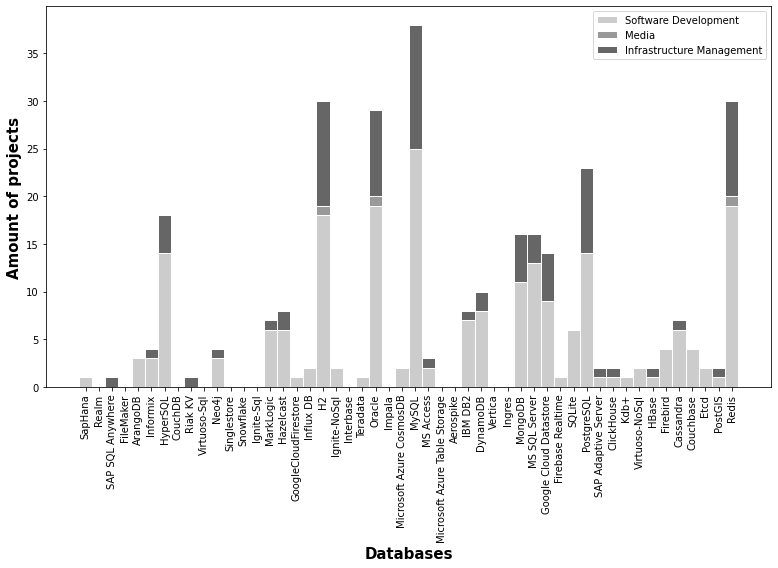

In [61]:
import numpy as np
import matplotlib.pyplot as plt
 
barWidth =1.0
fig = plt.subplots(figsize =(13, 7))

names_list = data_with_index.columns.to_list()
names_list.remove('name')
names_list.remove('domain')

domains = data_with_index.groupby('domain')

software_development = domains.get_group('Software Development')
software_development_sum = software_development.agg([np.sum])
software_development_results = software_development_sum.iloc[: , 2:].values.tolist()

media = domains.get_group('Media')
media_sum = media.agg([np.sum])
media_results = media_sum.iloc[: , 2:].values.tolist()

infrastructure_management = domains.get_group('Infrastructure Management')
infrastructure_management_sum = infrastructure_management.agg([np.sum])
infrastructure_management_result = infrastructure_management_sum.iloc[: , 2:].values.tolist()

br1 = np.arange(len(software_development_results[0]))
plt.bar(br1, software_development_results[0], color='#CCCCCC', edgecolor='white', width = barWidth, label ='Software Development')
plt.bar(br1, media_results[0], bottom=software_development_results[0], color='#999999', edgecolor='white', width = barWidth, label ='Media')
plt.bar(br1, infrastructure_management_result[0], bottom=[i+j for i,j in zip(software_development_results[0], media_results[0])], color='#666666', edgecolor='white', width = barWidth, label ='Infrastructure Management')
plt.xlabel('Databases', fontweight ='bold', fontsize = 15)
plt.ylabel('Amount of projects', fontweight ='bold', fontsize = 15)
plt.xticks(br1, names_list, rotation=90)

plt.legend()
plt.show()